In [1]:

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [127]:
import pandas as pd
import numpy as np


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras import Model
import keras

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from imblearn.pipeline import Pipeline as smote_pipeline

import joblib


In [3]:
df = pd.read_csv('../data/clean_data.csv')
df

,body_length,country,currency,delivery_method,description,fb_published,has_analytics,has_header,has_logo,listed,...,total_tickets_available,number_of_payouts,avg_quantity_sold,payee_name_in_org_name,venue_country_is_source_country,avg_cost_per_ticket,days_to_event,event_length,pop_country,fraud
0,3852.0,US,USD,0.0,0.723935,0,0,1.0,0,y,...,920.0,0.0,0.000000,True,True,0.226449,33.0,0.0,True,True
1,3499.0,US,USD,1.0,0.091689,0,0,0.0,1,n,...,100.0,49.0,12.500000,True,True,0.350000,28.0,0.0,True,False
2,2601.0,US,USD,1.0,0.095273,0,0,NaN,0,y,...,48.0,36.0,48.000000,True,True,1.948125,53.0,0.0,True,False
3,12347.0,IE,EUR,1.0,0.293555,0,0,0.0,1,y,...,30000.0,21.0,9.666667,True,False,0.000456,0.0,322.0,False,False
4,2417.0,US,USD,0.0,0.308245,1,0,0.0,0,y,...,264.0,49.0,4.875000,False,True,0.385417,63.0,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,667.0,US,USD,0.0,0.966564,0,0,NaN,1,n,...,400.0,0.0,0.000000,True,True,0.112500,10.0,0.0,True,True
14333,5812.0,US,USD,1.0,0.007159,0,0,1.0,0,y,...,3256.0,5.0,78.500000,False,True,0.013283,55.0,0.0,True,False
14334,557.0,NaN,USD,0.0,0.202241,1,0,0.0,1,y,...,148.0,1.0,0.200000,True,False,0.283784,89.0,0.0,False,False
14335,10873.0,US,USD,0.0,0.042906,0,0,0.0,1,y,...,100.0,128.0,0.000000,True,True,0.793300,5.0,0.0,True,False


In [4]:
pipe = joblib.load('../models/prediction_pipe.joblib')
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['body_length', 'description',
                                                   'name_length', 'num_payouts',
                                                   'user_age',
                                                   'avg_ticket_price',
                                                   'total_tickets_available',
                                                   'number_of_payouts',
                                                   'avg_quantity_sold',
                                                   'avg_cost_per_ticket',
                                                   'days_to_event',
                                                   'even...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'currency',
                                                   'delivery_method',
                                                   'fb_published',
                                                   'has_analytics',
                                                   'has_header', 'has_logo',
                                                   'listed', 'payout_type',
                                                   'show_map', 'venue_country',
                                                   'venue_state',
                                                   'payee_name_in_org_name',
                                                   'venue_country_is_source_country',
                                                   'pop_country'])])),
                ('smoter', SMOTE(n_jobs=-1)),
                ('cls', RandomForestClassifier(n_estimators=1000, n_jobs=-1))])

In [5]:
trans = pipe[:-1]
trans

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['body_length', 'description',
                                                   'name_length', 'num_payouts',
                                                   'user_age',
                                                   'avg_ticket_price',
                                                   'total_tickets_available',
                                                   'number_of_payouts',
                                                   'avg_quantity_sold',
                                                   'avg_cost_per_ticket',
                                                   'days_to_event',
                                                   'even...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'currency',
                                                   'delivery_method',
                                                   'fb_published',
                                                   'has_analytics',
                                                   'has_header', 'has_logo',
                                                   'listed', 'payout_type',
                                                   'show_map', 'venue_country',
                                                   'venue_state',
                                                   'payee_name_in_org_name',
                                                   'venue_country_is_source_country',
                                                   'pop_country'])])),
                ('smoter', SMOTE(n_jobs=-1))])

In [6]:
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   stratify=y)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11469 entries, 9326 to 3529
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   body_length                      11469 non-null  float64
 1   country                          11148 non-null  object 
 2   currency                         11469 non-null  object 
 3   delivery_method                  11456 non-null  float64
 4   description                      11469 non-null  float64
 5   fb_published                     11469 non-null  int64  
 6   has_analytics                    11469 non-null  int64  
 7   has_header                       7158 non-null   float64
 8   has_logo                         11469 non-null  int64  
 9   listed                           11469 non-null  object 
 10  name_length                      11469 non-null  float64
 11  num_payouts                      11469 non-null  float64
 12  payout_type     

In [7]:
pipe.fit_resample(X_train, y_train)


In [8]:
X_train_sm, y_train_sm = trans.fit_resample(X_train, y_train)
X_train_sm.shape

(20870, 569)

In [9]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train_sm, y_train_sm, test_size=0.20)

In [10]:
256//2

128

In [213]:
def model(num_hidden_nodes=64):
    nn = Sequential()
    nn.add(Dense(num_hidden_nodes, activation='relu', input_dim=569))
    nn.add(Dropout(rate=.05))
    nn.add(Dense(num_hidden_nodes, activation='relu'))
    nn.add(Dropout(rate=.10))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=[f1_score_k])
    return nn


In [214]:
clf = KerasClassifier(model, epochs=200, batch_size=50, verbose=1)

In [215]:
history = clf.fit(trans[:-1].transform(X_train).toarray(), y_train, validation_split=0.2)

Train on 9175 samples, validate on 2294 samples
Epoch 1/200
9175/9175 [==============================] - 1s 84us/step - loss: 0.4146 - f1_score_k: nan - val_loss: 0.2629 - val_f1_score_k: nan
Epoch 2/200
9175/9175 [==============================] - 1s 81us/step - loss: 0.2343 - f1_score_k: nan - val_loss: 0.1751 - val_f1_score_k: nan
Epoch 3/200
9175/9175 [==============================] - 1s 87us/step - loss: 0.1706 - f1_score_k: nan - val_loss: 0.1330 - val_f1_score_k: nan
Epoch 4/200
9175/9175 [==============================] - 1s 82us/step - loss: 0.1447 - f1_score_k: nan - val_loss: 0.1092 - val_f1_score_k: nan
Epoch 5/200
9175/9175 [==============================] - 1s 81us/step - loss: 0.1225 - f1_score_k: nan - val_loss: 0.0963 - val_f1_score_k: 0.7961
Epoch 6/200
9175/9175 [==============================] - 1s 82us/step - loss: 0.1120 - f1_score_k: nan - val_loss: 0.0903 - val_f1_score_k: 0.7979
Epoch 7/200
9175/9175 [==============================] - 1s 81us/step - loss: 0.10

9175/9175 [==============================] - 1s 86us/step - loss: 0.0586 - f1_score_k: nan - val_loss: 0.0615 - val_f1_score_k: 0.8594
Epoch 57/200
9175/9175 [==============================] - 1s 86us/step - loss: 0.0557 - f1_score_k: nan - val_loss: 0.0621 - val_f1_score_k: 0.8623
Epoch 58/200
9175/9175 [==============================] - 1s 87us/step - loss: 0.0566 - f1_score_k: nan - val_loss: 0.0621 - val_f1_score_k: 0.8595
Epoch 59/200
9175/9175 [==============================] - 1s 87us/step - loss: 0.0554 - f1_score_k: nan - val_loss: 0.0635 - val_f1_score_k: 0.8529
Epoch 60/200
9175/9175 [==============================] - 1s 87us/step - loss: 0.0550 - f1_score_k: nan - val_loss: 0.0608 - val_f1_score_k: 0.8623
Epoch 61/200
9175/9175 [==============================] - 1s 106us/step - loss: 0.0551 - f1_score_k: nan - val_loss: 0.0604 - val_f1_score_k: 0.8594
Epoch 62/200
9175/9175 [==============================] - 1s 104us/step - loss: 0.0535 - f1_score_k: nan - val_loss: 0.0609 

9175/9175 [==============================] - 1s 84us/step - loss: 0.0437 - f1_score_k: nan - val_loss: 0.0544 - val_f1_score_k: 0.8776
Epoch 112/200
9175/9175 [==============================] - 1s 86us/step - loss: 0.0441 - f1_score_k: 0.9099 - val_loss: 0.0539 - val_f1_score_k: 0.8714
Epoch 113/200
9175/9175 [==============================] - 1s 83us/step - loss: 0.0393 - f1_score_k: nan - val_loss: 0.0565 - val_f1_score_k: 0.8834
Epoch 114/200
9175/9175 [==============================] - 1s 80us/step - loss: 0.0408 - f1_score_k: nan - val_loss: 0.0540 - val_f1_score_k: 0.8756
Epoch 115/200
9175/9175 [==============================] - 1s 83us/step - loss: 0.0402 - f1_score_k: nan - val_loss: 0.0545 - val_f1_score_k: 0.8737
Epoch 116/200
9175/9175 [==============================] - 1s 82us/step - loss: 0.0438 - f1_score_k: 0.9233 - val_loss: 0.0551 - val_f1_score_k: 0.8803
Epoch 117/200
9175/9175 [==============================] - 1s 83us/step - loss: 0.0387 - f1_score_k: nan - val_los

Epoch 166/200
9175/9175 [==============================] - 1s 89us/step - loss: 0.0333 - f1_score_k: nan - val_loss: 0.0549 - val_f1_score_k: 0.8834
Epoch 167/200
9175/9175 [==============================] - 1s 85us/step - loss: 0.0336 - f1_score_k: nan - val_loss: 0.0543 - val_f1_score_k: 0.8803
Epoch 168/200
9175/9175 [==============================] - 1s 83us/step - loss: 0.0359 - f1_score_k: nan - val_loss: 0.0547 - val_f1_score_k: 0.8881
Epoch 169/200
9175/9175 [==============================] - 1s 92us/step - loss: 0.0328 - f1_score_k: 0.9269 - val_loss: 0.0541 - val_f1_score_k: 0.8877
Epoch 170/200
9175/9175 [==============================] - 1s 88us/step - loss: 0.0327 - f1_score_k: nan - val_loss: 0.0553 - val_f1_score_k: 0.8792
Epoch 171/200
9175/9175 [==============================] - 1s 87us/step - loss: 0.0332 - f1_score_k: 0.9284 - val_loss: 0.0543 - val_f1_score_k: 0.8780
Epoch 172/200
9175/9175 [==============================] - 1s 87us/step - loss: 0.0327 - f1_score_k:

In [138]:
predictions = clf.predict(X_train_sm.toarray())
f1_score(y_train_sm, predictions)

20870/20870 [==============================] - 1s 32us/step


0.9919481633236458

In [132]:
grid = {'num_hidden_nodes': [64, 128, 32, 16]}
search = GridSearchCV(clf, grid, scoring='f1', n_jobs=-1, cv=5)
search.fit(X_train_sm.toarray(), y_train_sm)
print(search.best_params_)
print(search.best_score_)


Epoch 1/50
20870/20870 [==============================] - 4s 183us/step - loss: 0.6793 - acc: 0.5820
Epoch 2/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.4351 - acc: 0.8457
Epoch 3/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.2309 - acc: 0.9210
Epoch 4/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.2065 - acc: 0.9297
Epoch 5/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.1844 - acc: 0.9375
Epoch 6/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.1672 - acc: 0.9416
Epoch 7/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.1608 - acc: 0.9449
Epoch 8/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.1474 - acc: 0.9467
Epoch 9/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.1425 - acc: 0.9488
Epoch 10/50
20870/20870 [==============================] - 1s 41us/step - loss: 0.1316 - acc: 0.952

In [196]:
y_train.value_counts() / y_train.shape[0]


False    0.909844
True     0.090156
Name: fraud, dtype: float64

In [143]:
X_test_processed = trans[:-1].transform(X_test)

In [216]:
test_predictions = clf.predict(X_test_processed)

2868/2868 [==============================] - 0s 37us/step


In [217]:
f1_score(y_test, test_predictions)

0.8727272727272728

In [168]:
import matplotlib.pyplot as plt


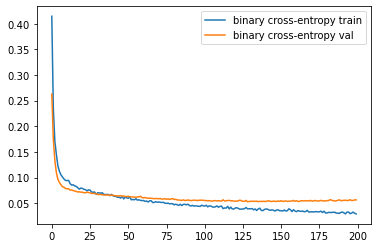

In [218]:
plt.plot(history.history['loss'], label='binary cross-entropy train')
plt.plot(history.history['val_loss'], label='binary cross-entropy val')
plt.legend()

In [171]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [174]:
import keras.backend as K

def f1_score_k(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score